In [1]:
# Importing Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Imorting ML Preprocessing and Metrics Libraries
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    Normalizer,
    RobustScaler,
    LabelEncoder,
    OneHotEncoder,
)

from sklearn.model_selection import cross_val_score, train_test_split
from category_encoders import LeaveOneOutEncoder
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Importing Classifiers
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from lightgbm import LGBMClassifier

# Some Extra Libraries
import warnings as w
w.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [2]:
train = pd.read_csv(r"../Data/train.csv")
test = pd.read_csv(r"../Data/test.csv")
original = pd.read_csv(r"../Data/original_data.csv")

This dataset provides a comprehensive and diverse analysis of an organization's employees, focusing on areas such as employee attrition, personal and work-related factors, and resources. main. Includes more than 35 attributes and their meanings are as follows:

|STT | Attribute Name | Meaning |
|:---| :--- |:--- |
| 1 | Age | Employee's age |
| 2 | Gender | Employee's Gender |
| 3 | BusinessTravel | Frequency of employees' business trips |
| 4 | DailyRate | Daily salary rate for employees |
| 5 | Department | Office of employees |
| 6 | DistanceFromHome | Distance from home in miles to work |
| 7 | Education | Level of education achieved by staff |
| 8 | EducationField | Employee's field of study |
| 9 | EmployeeCount | Total number of employees in the organization |
| 10 | EmployeeNumber | A unique identifier for each employee record |
| 11 | EnvironmentSatisfaction | Employee satisfaction with their working environment |
| 12 | HourlyRate | Hourly rate for employees |
| 13 | JobInvolvement | Level of involvement required for the employee's job |
| 14 | JobLevel | Employee's level of work |
| 15 | JobRole | The role of employees in the organization |
| 16 | JobSatisfaction | Employee satisfaction with their work |
| 17 | MaritalStatus | Employee's marital status |
| 18 | MonthlyIncome | Employee's monthly income |
| 19 | MonthlyRate | Monthly salary rate for employees |
| 20 | NumCompaniesWorked | Number of companies the employee worked for |
| 21 | Over18 | Whether the employee is over 18 years old |
| 22 | OverTime | Do employees work overtime |
| 23 | PercentSalaryHike | Salary increase rate for employees |
| 24 | PerformanceRating | The performance rating of the employee |
| 25 | RelationshipSatisfaction | Employee satisfaction with their relationships |
| 26 | StandardHours | Standard working hours for employees |
| 27 | StockOptionLevel | Employee stock option level |
| 28 | TotalWorkingYears | Total number of years the employee has worked |
| 29 | TrainingTimesLastYear | Number of times employees were taken to training in the last year |
| 30 | WorkLifeBalance | Employees' perception of their work-life balance |
| 31 | YearsAtCompany | Number of years employees have been with the company |
| 32 | YearsInCurrentRole | Number of years the employee has been in their current role |
| 33 | YearsSinceLastPromotion | Number of years since employee's last promotion |
| 34 | YearsWithCurrManager | Number of years an employee has been with their current manager |
| 35 | Attrition | Does the employee leave the organization |





##### **💬 Comment**: The following columns can be omitted because their values do not affect the analysis results
1. `Over18`: All values are `Y`
2. `EmployeeCount`: all values are `1.0`
3. `StandardHours`: all values are `80.0`
4. `EmployeeNumber`: is the `id` of the employee that has the same meaning as the `index` of each line
5. 'EmployeeCount': all values are `1.0`

In [3]:
att = {"Yes": 1, "No": 0}


def drop_cols(df):
    if df is train:
        df = df.drop(columns=["id", "Over18", "StandardHours", "EmployeeCount"])
    elif df is test:
        df = df.drop(columns=["Over18", "StandardHours", "EmployeeCount"])
    else:
        df["Attrition"] = df["Attrition"].map(att)
        df = df.drop(
            columns=["EmployeeNumber", "Over18", "StandardHours", "EmployeeCount"]
        )
    return df


original = drop_cols(original)
train = drop_cols(train)
test = drop_cols(test)

# Rectifying the anamolies in the training data according to the original data

In [4]:
train[train["Education"] == 15]
train[train["JobLevel"] == 7]
# Repalcing the outliers.
train.at[527, "Education"] = 5
train.at[1535, "JobLevel"] = 5
train.at[1398, "DailyRate"] = train["DailyRate"].median()

In [5]:
# Finding numrical Columns using the unique values.

num_cols = [col for col in train.columns if train[col].nunique() > 20]

In [6]:
# Converting the outliers in the numreic columns to the median.

for col in num_cols:
    if train[col].dtype != "object":
        train[col] = np.where(
            train[col] > train[col].quantile(0.95),
            train[col].median(),
            train[col],
        )
        train[col] = np.where(
            train[col] < train[col].quantile(0.05),
            train[col].median(),
            train[col],
        )
        pass
    else:
        pass
    
for col in num_cols:
    if original[col].dtype != "object":
        original[col] = np.where(
            original[col] > original[col].quantile(0.95),
            original[col].median(),
            original[col],
        )
        original[col] = np.where(
            original[col] < original[col].quantile(0.05),
            original[col].median(),
            original[col],
        )
        pass
    else:
        pass

In [7]:
# Concatenating the train and original data.
train = pd.concat([train, original], axis=0).reset_index(drop=True)
train.drop_duplicates(inplace=True)

# Feature Engineering

- ### Creating a new feature name risk_factor which takes in count for condition of the employee to leave or stay.
- ### Creating a new feature like dedication, jobskill, satisfaction, MonthlyRateIncome, DailyHoulryRate of Employee

In [8]:
def feature_engineering(df):
    df["risk_factors"] = df[
        [
            "RelationshipSatisfaction",
            "MonthlyIncome",
            "BusinessTravel",
            "Department",
            "EducationField",
            "Education",
            "JobInvolvement",
            "JobSatisfaction",
            "RelationshipSatisfaction",
            "StockOptionLevel",
            "TrainingTimesLastYear",
            "WorkLifeBalance",
            "OverTime",
        ]
    ].apply(
        lambda x: 0
        + (1 if x.MonthlyIncome < 3000 else 0)
        + (1 if x.BusinessTravel == "Travel_Frequently" else 0)
        + (1 if x.Department == "Human Resources" else 0)
        + (1 if x.EducationField in ["Human Resources", "Marketing"] else 0)
        + (1 if x.Education == 1 else 0)
        + (1 if x.JobInvolvement == 1 else 0)
        + (1 if x.JobSatisfaction == 1 else 0)
        + (1 if x.StockOptionLevel == 0 else 0)
        + (1 if x.TrainingTimesLastYear == 0 else 0)
        + (1 if x.WorkLifeBalance == 1 else 0)
        + (1 if x.OverTime == 1 else 0),
        axis=1,
    )

    df["Dedication"] = (
        df["YearsAtCompany"] + df["YearsInCurrentRole"] + df["TotalWorkingYears"]
    )
    df["JobSkill"] = df["JobInvolvement"] * df["JobLevel"]
    df["Satisfaction"] = df["EnvironmentSatisfaction"] * df["RelationshipSatisfaction"]
    df["MonthlyRateIncome"] = df["MonthlyIncome"] * df["MonthlyRate"]
    df["HourlyDailyRate"] = df["HourlyRate"] * df["DailyRate"]

    return df


train = feature_engineering(train)
test = feature_engineering(test)
# original = feature_risk_factors(original)

In [9]:
le = LabelEncoder()
loo = LeaveOneOutEncoder(sigma=0.05, random_state=0)

le_cols = ["Gender", "OverTime", "MaritalStatus", "PerformanceRating"]
ohe_cols = [
    "Department",
    "BusinessTravel",
]
map_cols = ["EducationField", "JobRole"]


def encode_labels(df, cols):
    for col in cols:
        df[col] = le.fit_transform(df[col])
    return df


def ohe_labels(df, cols):
    df = pd.get_dummies(df, columns=ohe_cols,dtype=int)
    return df

def map_labels(df, map_cols):
    for col in map_cols:
        if col == "EducationField":
            df[col] = df[col].map(
                {
                    "Life Sciences": 1,
                    "Medical": 2,
                    "Marketing": 3,
                    "Technical Degree": 4,
                    "Human Resources": 5,
                    "Other": 6,
                }
            )
        elif col == "JobRole":
            df[col] = df[col].map(
                {
                    "Sales Executive": 1,
                    "Research Scientist": 2,
                    "Laboratory Technician": 3,
                    "Manufacturing Director": 4,
                    "Healthcare Representative": 5,
                    "Manager": 6,
                    "Sales Representative": 7,
                    "Research Director": 8,
                    "Human Resources": 9,
                }
            )
    return df

train = map_labels(train, map_cols)
test = map_labels(test, map_cols)

train = encode_labels(train, le_cols)
test = encode_labels(test, le_cols)

train = ohe_labels(train, ohe_cols)
test = ohe_labels(test, ohe_cols)

# Checking VIF(Variance Inflation Factor) for Multicollinearity

In [10]:
train.head()

,Age,DailyRate,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,risk_factors,Dedication,JobSkill,Satisfaction,MonthlyRateIncome,HourlyDailyRate,Department_Human Resources,Department_Research & Development,Department_Sales,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
0,36.000,599.000,24.000,3,2,4,1,42.000,3,1,3,4,1,2596.000,5099.000,1,1,13,0,2,1,10.000,2,3,10.000,0,7,8,0,2,20.000,3,8,13237004.000,25158.000,0,1,0,0,1,0
1,35.000,921.000,8.000,3,6,1,1,46.000,3,1,7,1,1,2899.000,10778.000,1,0,17,0,4,1,4.000,3,3,4.000,2,0,3,0,2,10.000,3,4,31245422.000,42366.000,0,0,1,0,0,1
2,32.000,718.000,26.000,3,3,3,1,80.000,3,2,1,4,0,4627.000,16495.000,0,0,17,0,4,2,4.000,3,3,3.000,2,1,2,0,1,9.000,6,12,76322365.000,57440.000,0,0,1,0,0,1
3,38.000,890.000,2.000,3,2,3,0,40.000,3,2,5,1,1,5347.000,13384.000,3,0,14,0,3,0,15.000,1,1,6.000,0,0,2,0,3,21.000,6,9,71564248.000,35600.000,0,1,0,0,0,1
4,50.000,1017.000,5.000,4,2,2,0,37.000,3,5,6,1,2,4834.000,19805.000,1,1,13,0,3,0,9.000,0,3,5.000,14,4,10,1,3,28.000,15,6,95737370.000,37629.000,0,1,0,0,0,1


In [11]:
# Checking VIF for multicollinearity.

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

vif = calc_vif(train.drop(columns=["Attrition",'BusinessTravel_Non-Travel','TotalWorkingYears','YearsInCurrentRole',
                                'YearsAtCompany','Department_Research & Development','HourlyRate','DailyRate','JobLevel',
                                'JobInvolvement','EnvironmentSatisfaction','RelationshipSatisfaction','MonthlyIncome',
                                'MonthlyRate','BusinessTravel_Travel_Rarely','StockOptionLevel']))

In [12]:
vif

,variables,VIF
0,Age,32.981
1,DistanceFromHome,2.360
2,Education,9.804
3,EducationField,3.509
4,Gender,2.618
5,JobRole,5.332
6,JobSatisfaction,7.707
7,MaritalStatus,4.398
8,NumCompaniesWorked,2.378
9,OverTime,1.363


In [13]:
vif_features = list(vif['variables'].values)
target = 'Attrition'
print(len(vif_features))

25


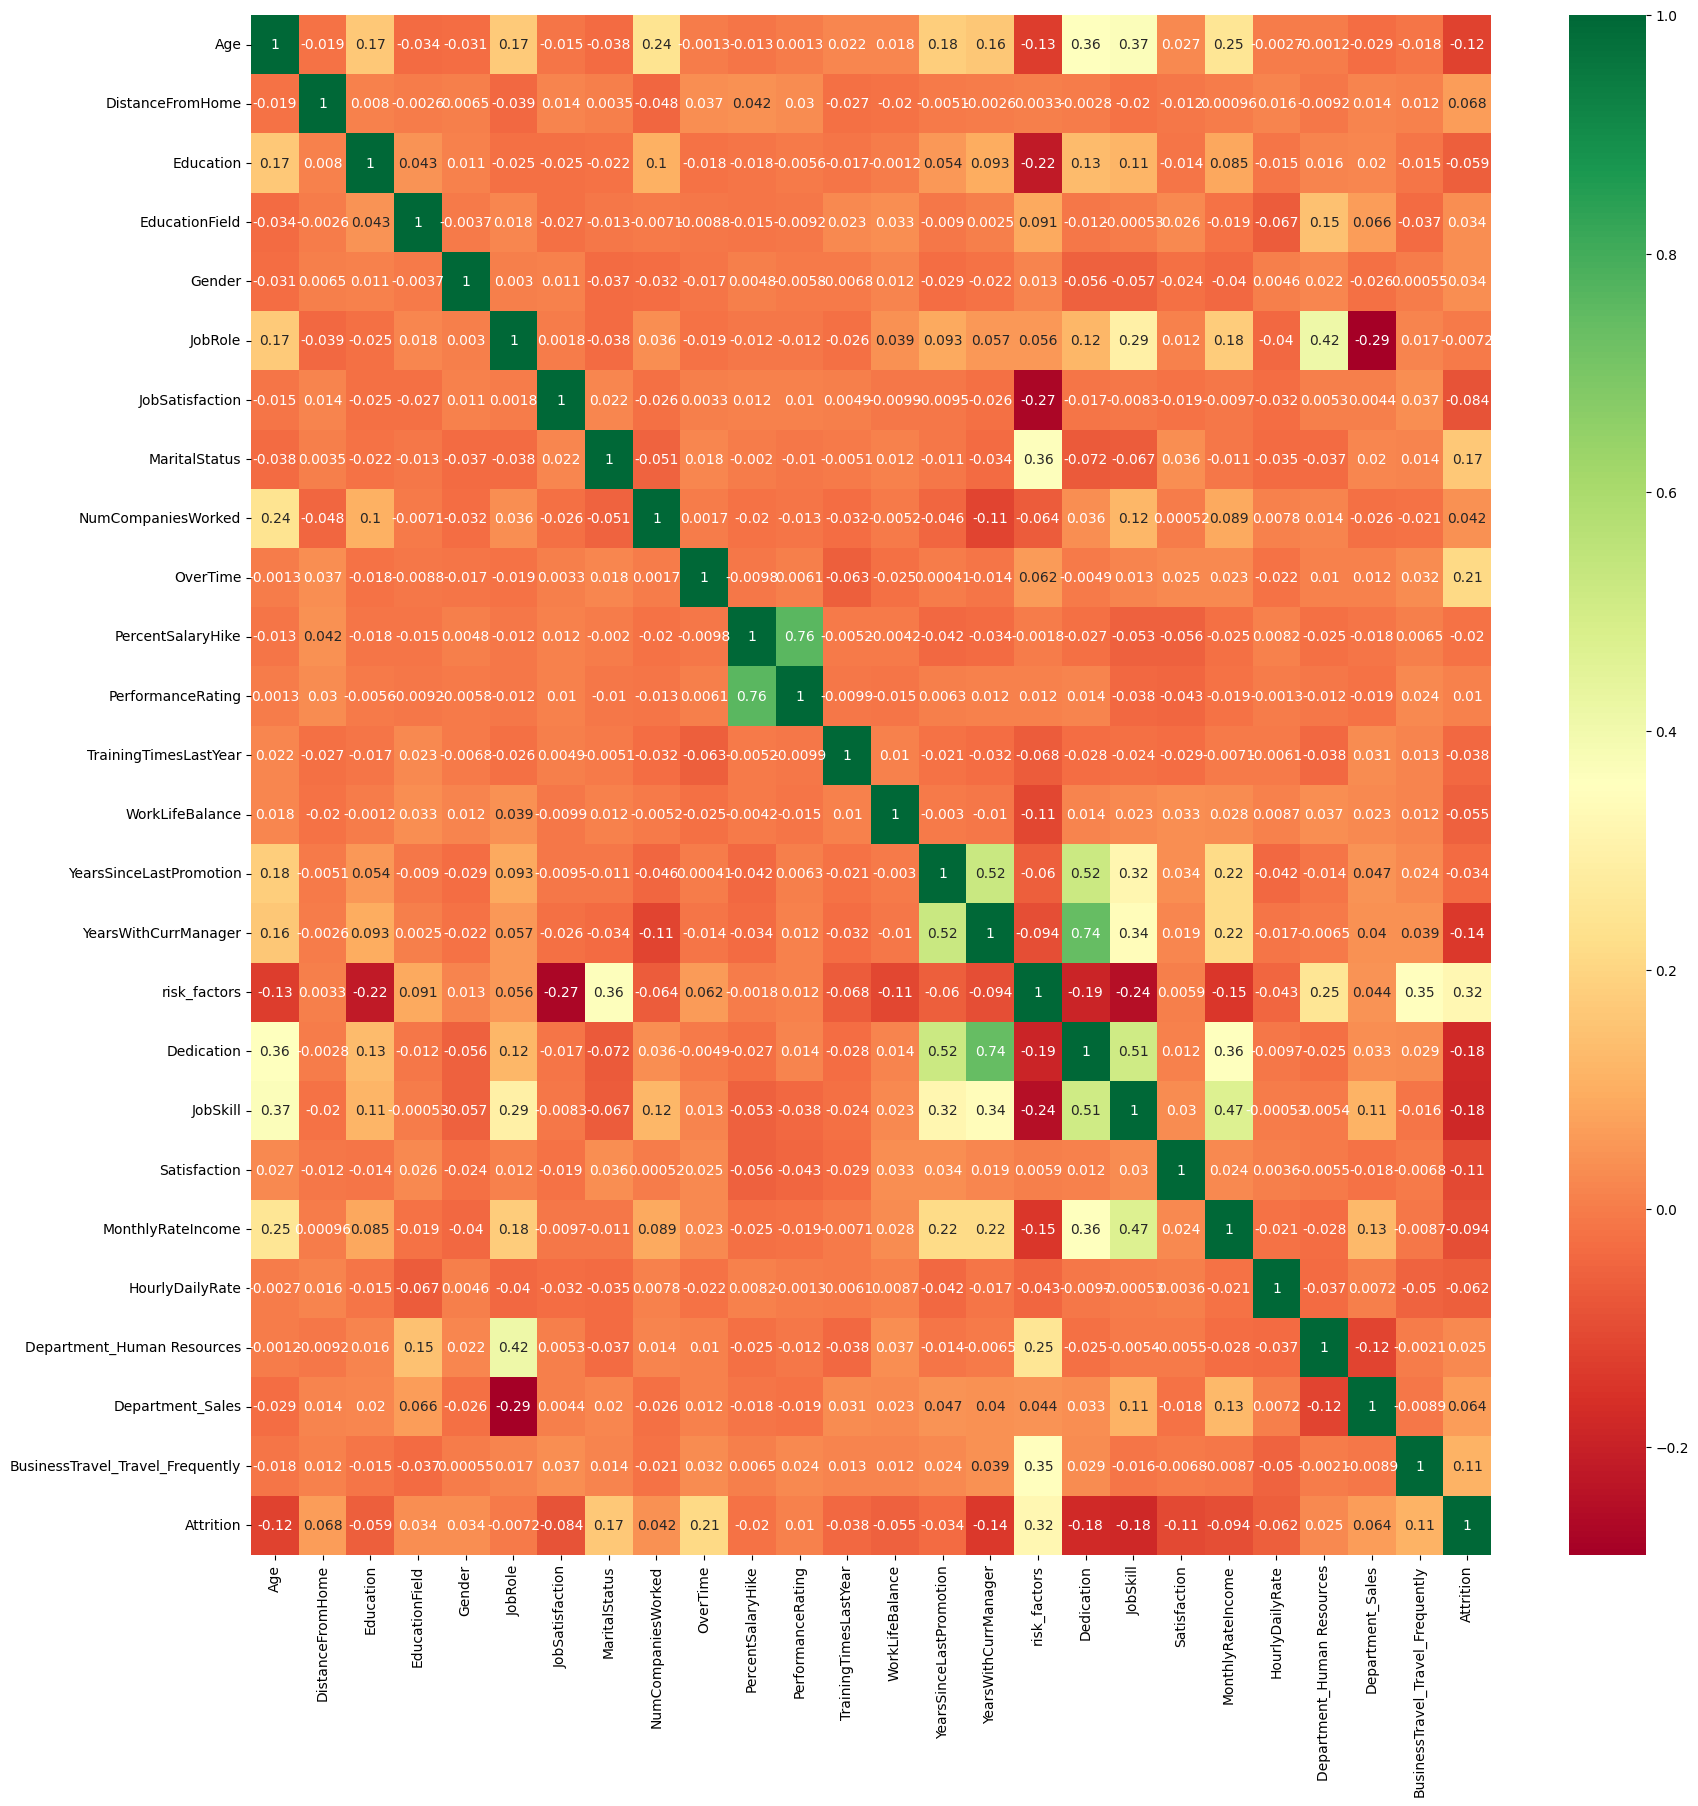

In [14]:
# ploting the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(train[vif_features + [target]].corr(), annot=True, cmap="RdYlGn")
plt.show()

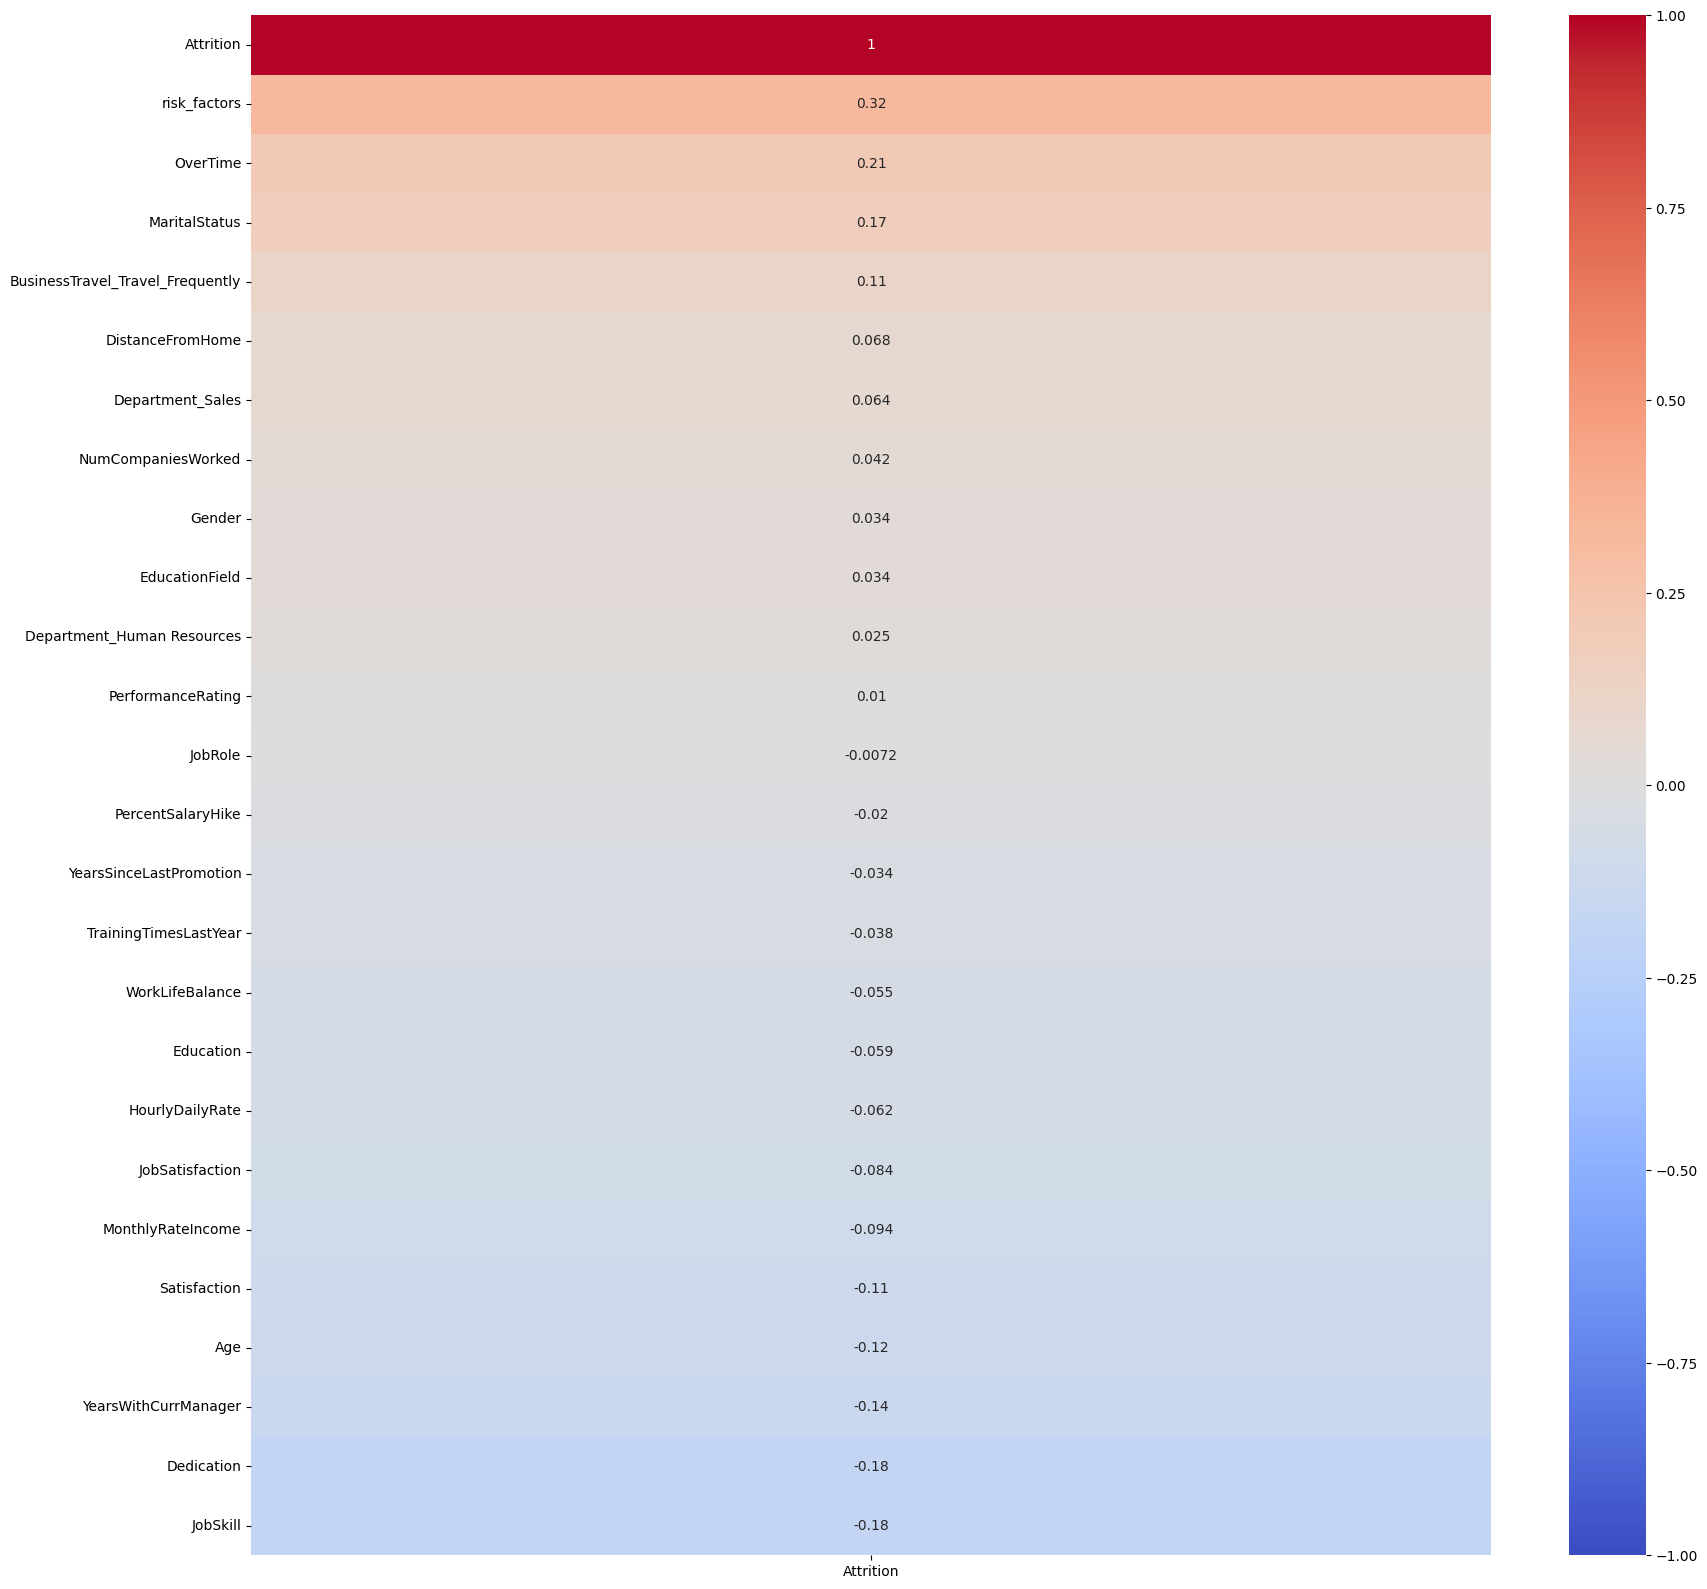

In [15]:
# Plotting the Correlation With Only Attrition Column
plt.figure(figsize=(20, 20))

sns.heatmap(
    train[vif_features+[target]].corr()[[target]].sort_values(by=target, ascending=False),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="coolwarm",
)
plt.show()

In [16]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

# Step 1: Load your train into X (features) and y (target variable)
X = train.drop(target, axis=1)
X = X[vif_features]
# Features
y = train[target]  # Target variable

# Step 2: Create an instance of the model you want to use for feature selection
estimator = XGBClassifier(random_state=101,verbosity=0,)

# Step 3: Create an instance of the RFE with the desired number of features
rfe = RFECV(estimator,cv=5,scoring='precision',min_features_to_select=15,n_jobs=-1)

# Step 4: Fit the RFE model to your train
rfe.fit(X, y)

# Step 5: Get the selected features
selected_features = X.columns[rfe.support_]

# Print the selected features
print(selected_features)
print(len(selected_features))

Index(['Age', 'DistanceFromHome', 'Education', 'EducationField', 'Gender',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'risk_factors', 'Dedication', 'JobSkill', 'Satisfaction',
       'MonthlyRateIncome', 'HourlyDailyRate', 'Department_Human Resources',
       'Department_Sales', 'BusinessTravel_Travel_Frequently'],
      dtype='object')
24


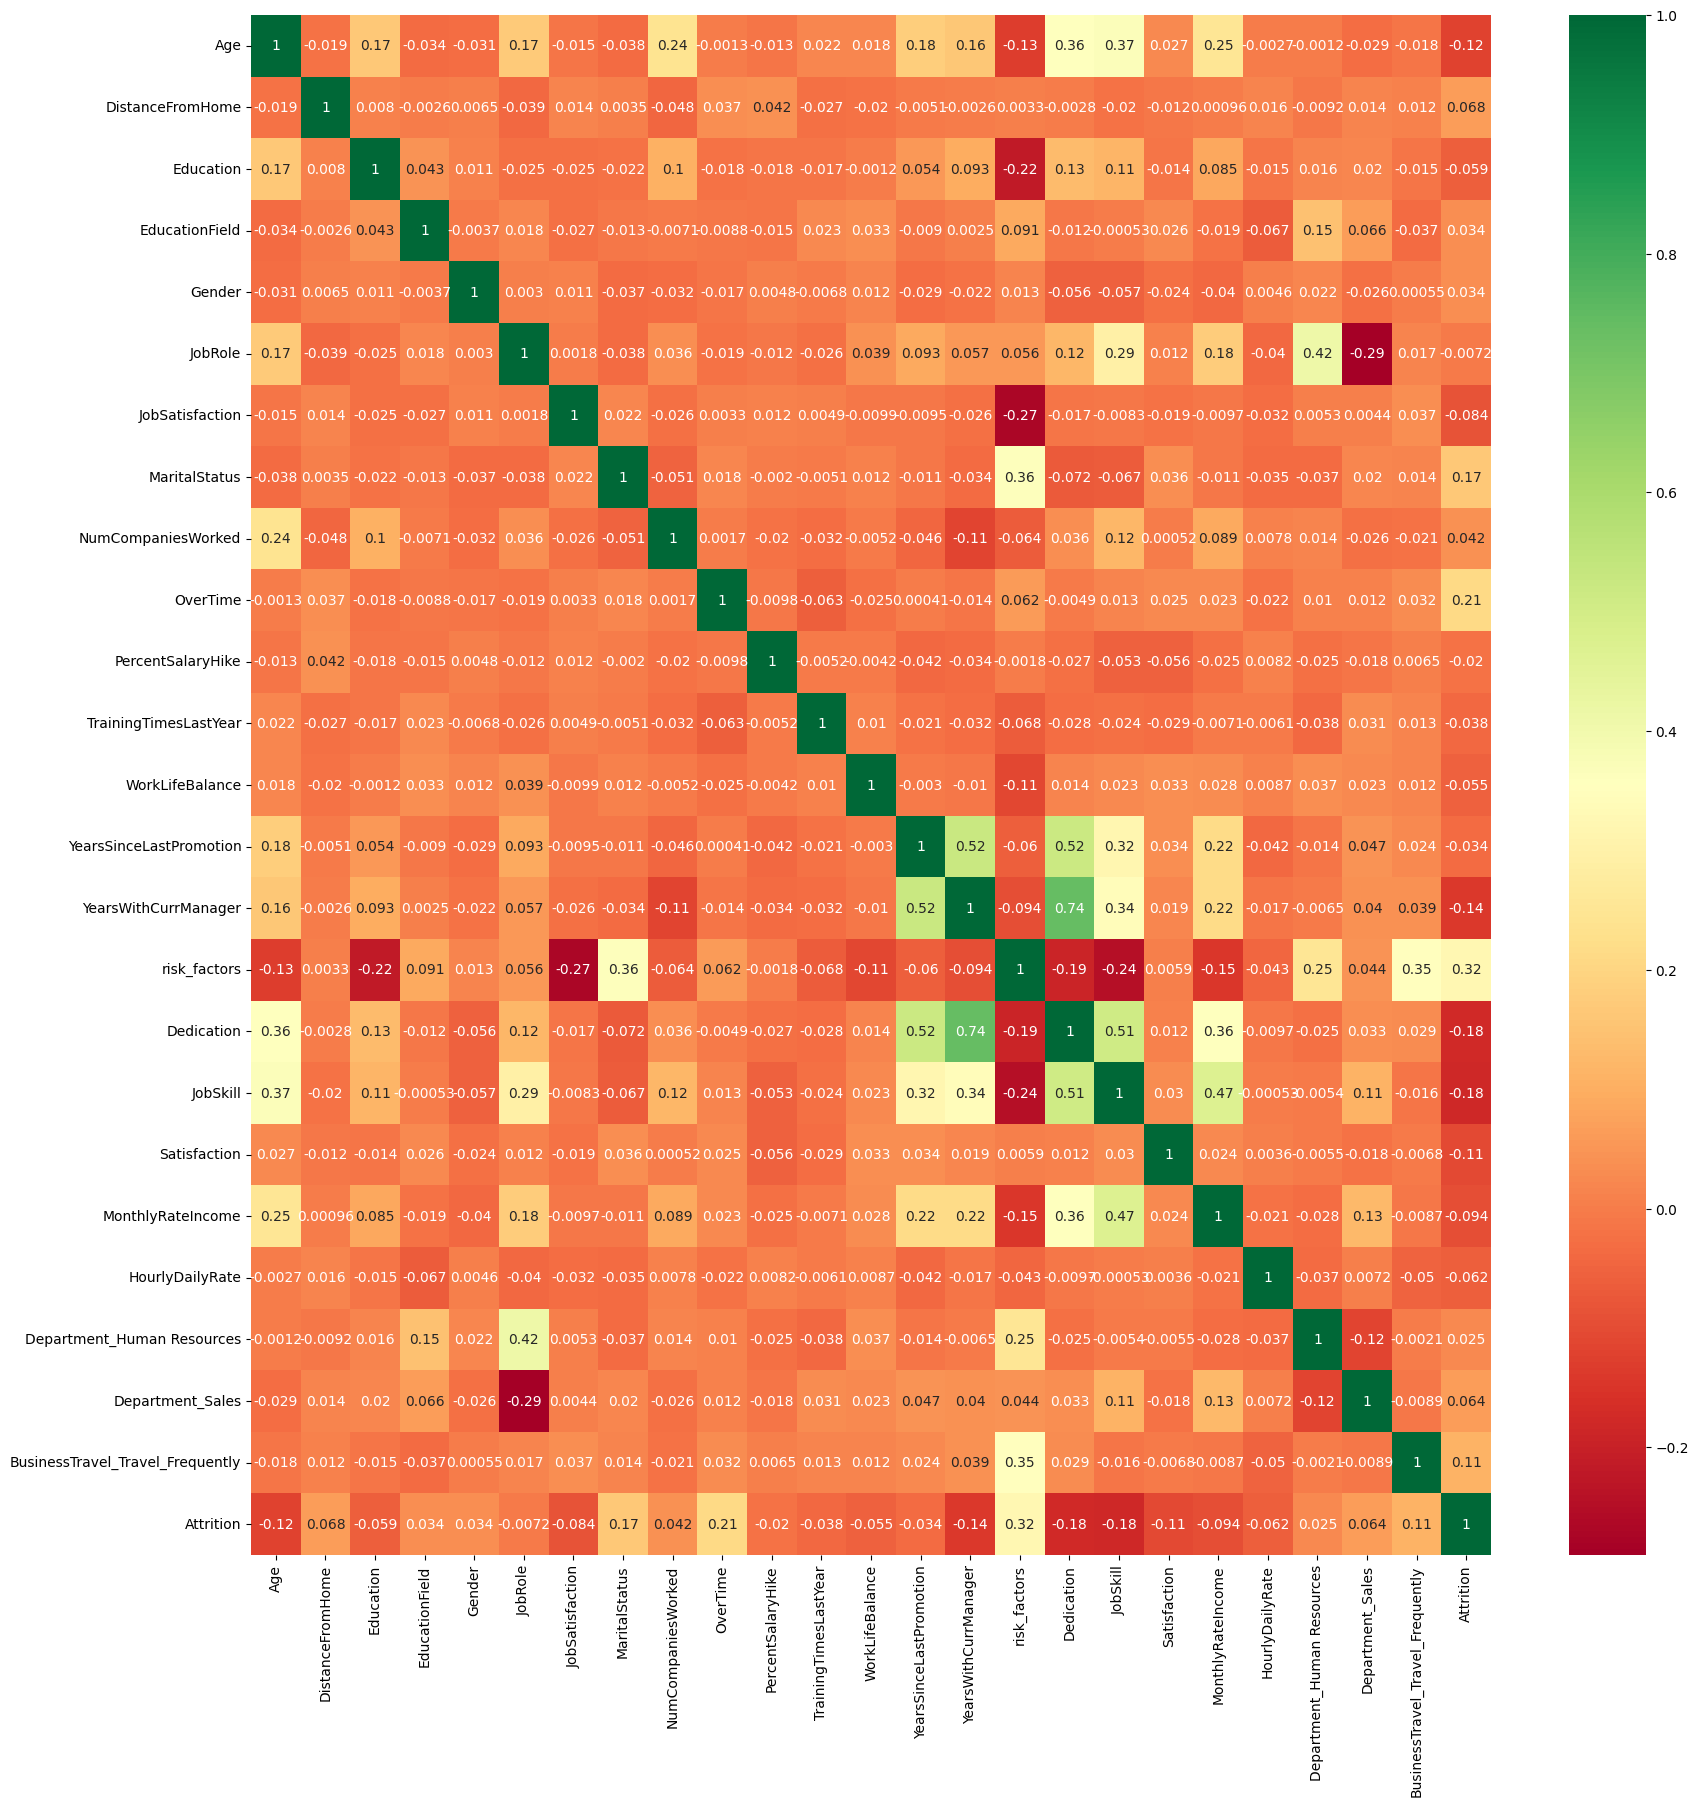

In [17]:
# Print the correlation matrix of the selected features
plt.figure(figsize=(20, 20))
sns.heatmap(train[list(selected_features) + [target]].corr(), annot=True, cmap="RdYlGn")
plt.show()

In [18]:
# Splitting the data into train and validation set
X = train[list(selected_features)]
y = train[target]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=101, stratify=y
)

# print(X_train.shape)
# print(X_valid.shape)
# print(y_train.shape)
# print(y_valid.shape)

# # Scaling the data using Robust Scaler

# scaler = RobustScaler()

# cols_to_scale = [col for col in X_train.columns if X_train[col].nunique() > 20]

# print(cols_to_scale)

# X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
# X_valid[cols_to_scale] = scaler.transform(X_valid[cols_to_scale])

# Model Building

In [19]:
# Making a list of tuples containing the model name and the model object.
models = [
    ("Logistic Regression", LogisticRegression(penalty="l1",solver='liblinear', random_state=101)),
    ("Decision Tree", DecisionTreeClassifier(random_state=101)),
    ("Random Forest", RandomForestClassifier(random_state=101,n_jobs=-1)),
    ("XGBoost", XGBClassifier(verbosity=0)),
    ("LightGBM", LGBMClassifier(random_state=101,n_jobs=-1)),
    ("CatBoost", CatBoostClassifier(verbose=0, random_state=101,)),
    ('SVM', SVC(random_state=101)),
    ('KNN', KNeighborsClassifier(n_jobs=-1)),
    ('Naive Bayes', GaussianNB()),
    ('Extra Trees', ExtraTreesClassifier(random_state=101, n_jobs=-1)),
    ('AdaBoost', AdaBoostClassifier(ExtraTreesClassifier(),random_state=101)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=101)),
]

from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

In [20]:
# Creating a dataframe to store the result metrics of each model.
metrics = pd.DataFrame(
    columns=[
        "Model",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
        "ROC_AUC_Score",
        "Cross Validation Score",
    ]
)

# Iterating through the list of models.

for name, model in models:
    # Cross validating the model.
    cv = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy", n_jobs=-1)
    # Appending the metrics to the dataframe.
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)
    rec = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred)
    # Adding these metrics to the dataframe without appending them to the dataframe.
    metrics.loc[len(metrics)] = [name, acc, prec, rec, f1, roc_auc, np.mean(cv)]
    print("Confusion Matrix for", name)
    print(confusion_matrix(y_valid, y_pred))
    print("Classification Report for", name)
    print(classification_report(y_valid, y_pred))
    print("--------------------------------------------------")

Confusion Matrix for Logistic Regression
[[530  13]
 [ 65  22]]
Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       543
           1       0.63      0.25      0.36        87

    accuracy                           0.88       630
   macro avg       0.76      0.61      0.65       630
weighted avg       0.85      0.88      0.85       630

--------------------------------------------------
Confusion Matrix for Decision Tree
[[472  71]
 [ 56  31]]
Classification Report for Decision Tree
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       543
           1       0.30      0.36      0.33        87

    accuracy                           0.80       630
   macro avg       0.60      0.61      0.60       630
weighted avg       0.81      0.80      0.81       630

--------------------------------------------------
Confusion Matrix for Random Forest
[

In [21]:
metrics.set_index("Model").sort_values(by="Precision", ascending=False)

,Accuracy,Precision,Recall,F1 Score,ROC_AUC_Score,Cross Validation Score
Model,,,,,,
AdaBoost,0.879,0.762,0.184,0.296,0.587,0.874
Random Forest,0.879,0.739,0.195,0.309,0.592,0.874
Extra Trees,0.881,0.731,0.218,0.336,0.603,0.872
Gradient Boosting,0.894,0.708,0.391,0.504,0.683,0.872
XGBoost,0.889,0.673,0.379,0.485,0.675,0.868
CatBoost,0.889,0.673,0.379,0.485,0.675,0.876
LightGBM,0.886,0.653,0.368,0.471,0.668,0.872
Logistic Regression,0.876,0.629,0.253,0.361,0.614,0.881
Decision Tree,0.798,0.304,0.356,0.328,0.613,0.805


In [22]:
# Using Smote to balance the data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=101)
X_smote, y_smote = smote.fit_resample(X, y)

# Splitting the data into train and validation set
X_train_smote, X_valid_smote, y_train_smote, y_valid_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=101, stratify=y_smote
)
# scaler_for_smote = RobustScaler()

# cols_to_scale = [col for col in X_train_smote.columns if X_train_smote[col].nunique() > 20]

# X_train_smote[cols_to_scale] = scaler_for_smote.fit_transform(X_train_smote[cols_to_scale])
# X_valid_smote[cols_to_scale] = scaler_for_smote.transform(X_valid_smote[cols_to_scale])


# print(X_smote.shape)
# print(y_smote.shape)
# print(X_train_smote.shape)
# print(X_valid_smote.shape)
# print(y_train_smote.shape)
# print(y_valid_smote.shape)

In [23]:
# Creating a dataframe to store the result smote_metrics of each model.
smote_metrics = pd.DataFrame(
    columns=[
        "Model",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
        "ROC_AUC_Score",
        "Cross Validation Score",
    ]
)

# Iterating through the list of models.

for name, model in models:
    # Cross validating the model.
    cv = cross_val_score(
        model, X_train_smote, y_train_smote, cv=kfold, scoring="accuracy", n_jobs=-1
    )
    # Appending the smote_metrics to the dataframe.
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_valid_smote)
    acc = accuracy_score(y_valid_smote, y_pred)
    prec = precision_score(y_valid_smote, y_pred)
    rec = recall_score(y_valid_smote, y_pred)
    f1 = f1_score(y_valid_smote, y_pred)
    roc_auc = roc_auc_score(y_valid_smote, y_pred)
    smote_metrics.loc[len(smote_metrics)] = [
        name,
        acc,
        prec,
        rec,
        f1,
        roc_auc,
        np.mean(cv),
    ]
    print("Confusion Matrix for", name)
    print(confusion_matrix(y_valid_smote, y_pred))
    print("Classification Report for", name)
    print(classification_report(y_valid_smote, y_pred))
    
    print("--------------------------------------------------")

Confusion Matrix for Logistic Regression
[[399 143]
 [121 421]]
Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       542
           1       0.75      0.78      0.76       542

    accuracy                           0.76      1084
   macro avg       0.76      0.76      0.76      1084
weighted avg       0.76      0.76      0.76      1084

--------------------------------------------------
Confusion Matrix for Decision Tree
[[437 105]
 [ 79 463]]
Classification Report for Decision Tree
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       542
           1       0.82      0.85      0.83       542

    accuracy                           0.83      1084
   macro avg       0.83      0.83      0.83      1084
weighted avg       0.83      0.83      0.83      1084

--------------------------------------------------
Confusion Matrix for Random Forest
[

In [24]:
smote_metrics.set_index("Model").sort_values(by="Precision", ascending=False)

,Accuracy,Precision,Recall,F1 Score,ROC_AUC_Score,Cross Validation Score
Model,,,,,,
XGBoost,0.940,0.931,0.950,0.941,0.940,0.919
LightGBM,0.935,0.929,0.941,0.935,0.935,0.910
CatBoost,0.921,0.919,0.923,0.921,0.921,0.914
Extra Trees,0.925,0.914,0.939,0.926,0.925,0.903
Random Forest,0.916,0.912,0.921,0.916,0.916,0.897
AdaBoost,0.922,0.907,0.939,0.923,0.922,0.902
Gradient Boosting,0.877,0.861,0.900,0.880,0.877,0.868
Decision Tree,0.830,0.815,0.854,0.834,0.830,0.780
Logistic Regression,0.756,0.746,0.777,0.761,0.756,0.779


In [25]:
# Using best 4 models for then taking the average of the predictions
estimators = [
    ("Catboost", CatBoostClassifier(verbose=0,random_state=101)),
    ("XGBoost", XGBClassifier(verbosity=0)),
    ("LightGBM", LGBMClassifier(random_state=101,n_jobs=-1)),
    # ('Extra Trees', ExtraTreesClassifier(random_state=101)),
    # ('RFC', RandomForestClassifier(random_state=101)),
]

# Creating a dataframe to store the result smote_metrics of each model.

res = test[["id"]]
for name, model in estimators:
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict_proba(test[selected_features])
    # Saving the predictions in a dataframe.
    res[name] = y_pred[:, 1]
    pass

# Taking the average of the predictions.
res["Attrition"] = res.drop("id", axis=1).mean(axis=1)

# Saving the predictions in a csv file.
res[["id", "Attrition"]].to_csv("submission.csv", index=False)

# Creating model using best estimator Random Forest Classifier with Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
# Creating a parameter grid to pass in the GridSearchCV.

param_grid = {
    "n_estimators": [100, 150, 200, 250],
    "max_depth": [1, 2, 3, 4, 5],
    "min_samples_split": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3, 4, 5],
}

# Creating the GridSearchCV object.

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=101),
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    cv=5,
    verbose=1,
)

# Fitting the GridSearchCV object on the train set.

grid.fit(X_train_smote, y_train_smote)

# Getting the best parameters.

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

rfc = RandomForestClassifier(random_state=101)

# Fitting the model on the train set.

rfc.fit(X_train_smote, y_train_smote)

# Predicting the target variable on the train set.

y_pred = rfc.predict(X_valid_smote)

# Getting the roc_auc_score on the train set.

print("ROC_AUC_Score", roc_auc_score(y_valid_smote, y_pred))
print("Accuracy", accuracy_score(y_valid_smote, y_pred))
print("Confusion Matrix\n", confusion_matrix(y_valid_smote, y_pred))

# Feature Importance

# Zip the feature names with the feature importances and sort them.

imp_features_rfc = sorted(
    zip(features, rfc.feature_importances_), key=lambda x: x[1], reverse=True
)

# Plotting a horizontal barplot.

plt.figure(figsize=(10, 8))
sns.barplot(x=[x[1] for x in imp_features_rfc], y=[x[0] for x in imp_features_rfc])
plt.title("Feature Importance")
plt.show()

ROC_AUC_Score 0.9400369003690039
Accuracy 0.9400369003690037
Confusion Matrix
 [[504  38]
 [ 27 515]]


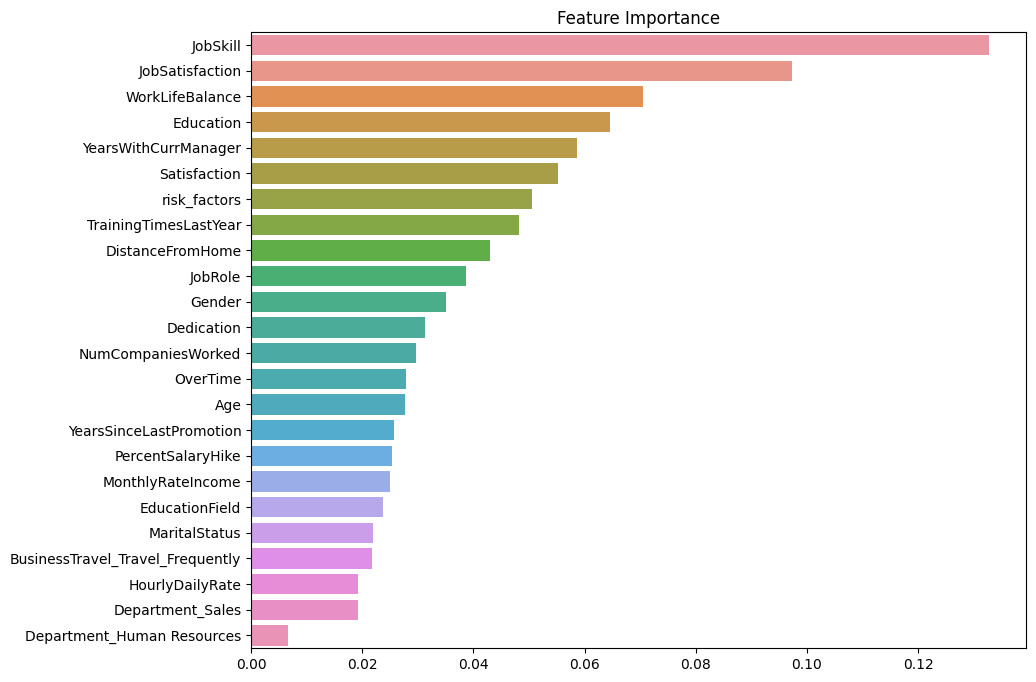

In [26]:
# Creating a Random Forest Classifier with the best parameters.

xgb = XGBClassifier(verbosity=0, random_state=101)

# Fitting the model on the train set.

xgb.fit(X_train_smote, y_train_smote)

# Predicting the target variable on the train set.

y_pred = xgb.predict(X_valid_smote)

# Getting the roc_auc_score on the train set.

print("ROC_AUC_Score", roc_auc_score(y_valid_smote, y_pred))
print("Accuracy", accuracy_score(y_valid_smote, y_pred))
print("Confusion Matrix\n", confusion_matrix(y_valid_smote, y_pred))

# Feature Importance

# Zip the feature names with the feature importances and sort them.

imp_features_xgb = sorted(
    zip(selected_features, xgb.feature_importances_), key=lambda x: x[1], reverse=True
)

# Plotting a horizontal barplot.

plt.figure(figsize=(10, 8))
sns.barplot(x=[x[1] for x in imp_features_xgb], y=[x[0] for x in imp_features_xgb])
plt.title("Feature Importance")
plt.show()

ROC_AUC_Score 0.9206642066420664
Accuracy 0.9206642066420664
Confusion Matrix
 [[498  44]
 [ 42 500]]


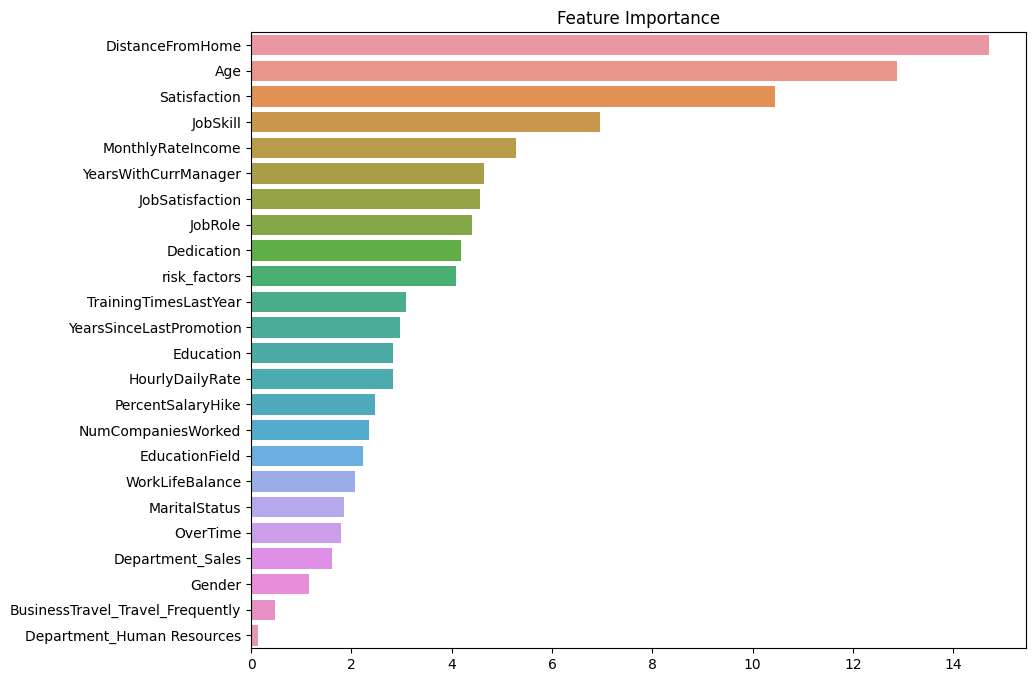

In [27]:
# Creating a Random Forest Classifier with the best parameters.

cb = CatBoostClassifier(verbose=0, random_state=101)

# Fitting the model on the train set.

cb.fit(X_train_smote, y_train_smote)

# Predicting the target variable on the train set.

y_pred = cb.predict(X_valid_smote)

# Getting the roc_auc_score on the train set.

print("ROC_AUC_Score", roc_auc_score(y_valid_smote, y_pred))
print("Accuracy", accuracy_score(y_valid_smote, y_pred))
print("Confusion Matrix\n", confusion_matrix(y_valid_smote, y_pred))

# Feature Importance

# Zip the feature names with the feature importances and sort them.

imp_features_cb = sorted(
    zip(selected_features, cb.feature_importances_), key=lambda x: x[1], reverse=True
)

# Plotting a horizontal barplot.

plt.figure(figsize=(10, 8))
sns.barplot(x=[x[1] for x in imp_features_cb], y=[x[0] for x in imp_features_cb])
plt.title("Feature Importance")
plt.show()

ROC_AUC_Score 0.9345018450184501
Accuracy 0.9345018450184502
Confusion Matrix
 [[503  39]
 [ 32 510]]


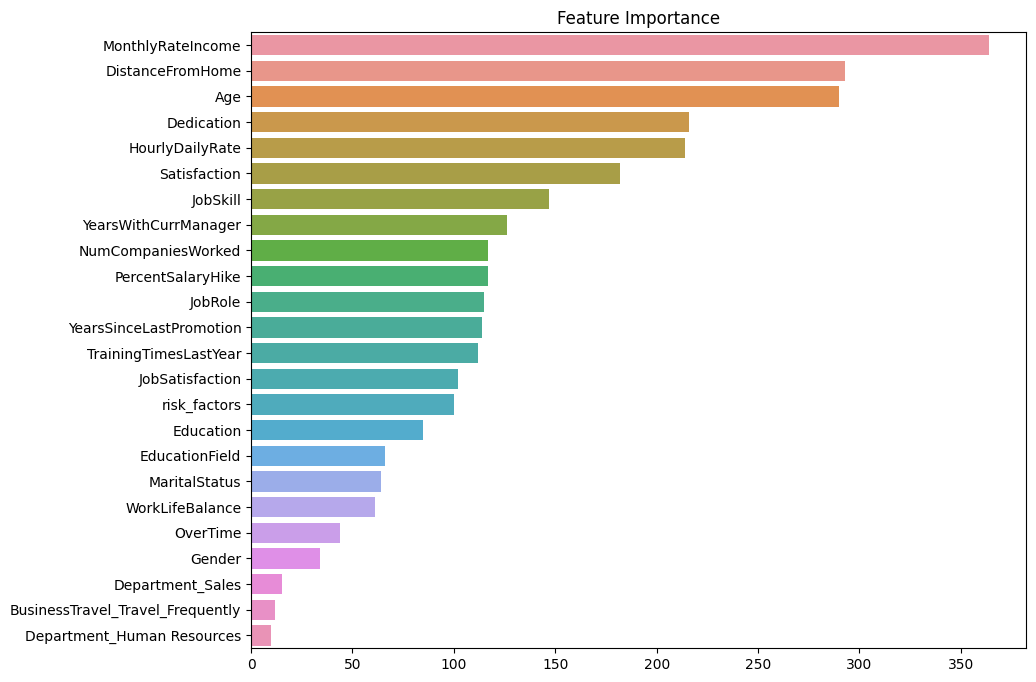

In [28]:
# Creating a Random Forest Classifier with the best parameters.

lgbm = LGBMClassifier(random_state=101,n_jobs=-1)

# Fitting the model on the train set.

lgbm.fit(X_train_smote, y_train_smote)

# Predicting the target variable on the train set.

y_pred = lgbm.predict(X_valid_smote)

# Getting the roc_auc_score on the train set.

print("ROC_AUC_Score", roc_auc_score(y_valid_smote, y_pred))
print("Accuracy", accuracy_score(y_valid_smote, y_pred))
print("Confusion Matrix\n", confusion_matrix(y_valid_smote, y_pred))

# Feature Importance

# Zip the feature names with the feature importances and sort them.

imp_features_lgbm = sorted(
    zip(selected_features, lgbm.feature_importances_), key=lambda x: x[1], reverse=True
)

# Plotting a horizontal barplot.

plt.figure(figsize=(10, 8))
sns.barplot(x=[x[1] for x in imp_features_lgbm], y=[x[0] for x in imp_features_lgbm])
plt.title("Feature Importance")
plt.show()

# Creating a Random Forest Classifier with the best parameters.

extratree = ExtraTreesClassifier(random_state=101)

# Fitting the model on the train set.

extratree.fit(X_train_smote, y_train_smote)

# Predicting the target variable on the train set.

y_pred = extratree.predict(X_valid_smote)

# Getting the roc_auc_score on the train set.

print("ROC_AUC_Score", roc_auc_score(y_valid_smote, y_pred))
print("Accuracy", accuracy_score(y_valid_smote, y_pred))
print("Confusion Matrix\n", confusion_matrix(y_valid_smote, y_pred))

# Feature Importance

# Zip the feature names with the feature importances and sort them.

imp_features_extratree = sorted(
    zip(features, extratree.feature_importances_), key=lambda x: x[1], reverse=True
)

# Plotting a horizontal barplot.

plt.figure(figsize=(10, 8))
sns.barplot(x=[x[1] for x in imp_features_extratree], y=[x[0] for x in imp_features_extratree])
plt.title("Feature Importance")
plt.show()

In [29]:
# Getting the best 4 features from each model.

# rfc_features = [x[0] for x in imp_features_rfc[:4]]
xgb_features = [x[0] for x in imp_features_xgb[:3]]
cb_features = [x[0] for x in imp_features_cb[:3]]
lgbm_features = [x[0] for x in imp_features_lgbm[:3]]
# extratree_features = [x[0] for x in imp_features_extratree[:4]]

# print("RFC Features", rfc_features)
print("XGB Features", xgb_features)
print("CB Features", cb_features)
# print("ExtraTree Features", extratree_features)
print("LGBM Features", lgbm_features)

# Taking Common Features from all the models.

common_features = list(set(xgb_features) | set(cb_features) | set(lgbm_features))

print("Common Features", common_features)

XGB Features ['JobSkill', 'JobSatisfaction', 'WorkLifeBalance']
CB Features ['DistanceFromHome', 'Age', 'Satisfaction']
LGBM Features ['MonthlyRateIncome', 'DistanceFromHome', 'Age']
Common Features ['MonthlyRateIncome', 'Age', 'Satisfaction', 'WorkLifeBalance', 'JobSkill', 'DistanceFromHome', 'JobSatisfaction']


# SUMMARY 

- 1. Feature Engineered the data by creating new features like risk_factor, dedication, jobskill, satisfaction, MonthlyRateIncome, DailyHoulryRate of Employee. Applied RFE to get the 15 best features for the model.
- 2. Used Random Forest, XGBoost, LightGBM, CatBoost and took the average of the predictions of all the models to get the final predictions. Also used Hyperparameter Tuning to get the best parameters for the model. Focused on precision of the model as we want to predict the employees who are going to leave the company. Used SMOTE to balance the data increasing the precision of the model from 0.574 to 0.913 with an ROC-AUC score of 0.922.
- 3. 'WorkLifeBalance', 'Age', 'PercentSalaryHike', 'risk_factors', 'Education', 'YearsWithCurrManager', 'DistanceFromHome' are the most important features.